**余盈蓓；語碩二；110555009**\
**111-2 Computational Linguistics**
<p align="center", style = "font-size:18pt">
<b>3rd Assignment<br>
Logistic Regression and Gradient Descent</b>
</p>

<p align="center">
以下將使用從<a href = "https://www.kaggle.com/datasets/kreeshrajani/human-stress-prediction" target="_blank">Kaggle</a>取得的<a href = "https://www.reddit.com/" target = "_blank">Reddit</a>上的貼文以情感分析做壓力偵測。<br>
<br>

<p style = "font-size:14pt">
<b>Step 1. 資料前處理</b>
</p>
<p style = "font-size:12pt">
✨資料讀入
</p>

In [1]:
import pandas as pd

data = pd.read_csv("Stress.csv")

In [2]:
data.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB


<p style = "font-size:12pt">
✨資料簡述<br>
&emsp;&ensp;該dataset中包含下列七個column：<br>
&emsp;&ensp;🎲 Reddit看板<br>
&emsp;&ensp;🎲 文章id<br>
&emsp;&ensp;🎲 句子index：檔案描述只提到是句子的index，但沒說是什麼句子在哪裡的index。<br>
&emsp;&ensp;🎲 po文內容<br>
&emsp;&ensp;🎲 標記：po文者是否感受到壓力<br>
&emsp;&ensp;🎲 自信程度：發文者的自信程度（未提及如何計算）<br>
&emsp;&ensp;🎲 發文時間 <br>
</p>

In [4]:
data["label"].value_counts()

1    1488
0    1350
Name: label, dtype: int64

<p style = "font-size:14pt">
<b>Step 2. 特徵萃取</b>
</p>
<p style = "font-size:12pt">
✨情感分數計算<br>
&emsp;&ensp;以下使用<code>nltk</code>中提供的<code>vader</code>套件計算每一則評論情感分數。<br>
</p>

In [5]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

<p style = "font-size:12pt">
&emsp;&ensp;取用正向分數、負向分數跟綜合分數來作為特徵，分別看評論的正向情緒傾向、負向情緒傾向、中立情緒分數跟整體情緒傾向是不是都會影響到模型判斷。
</p>

In [6]:
sid = SentimentIntensityAnalyzer() # 初始化工具
positive_score = []
negative_score = []
neutral_score = []
sentiment_score = []

for comment in data["text"]:
    result = sid.polarity_scores(comment)
    positive_score.append(result["pos"])
    negative_score.append(result["neg"])
    neutral_score.append(result["neu"])
    sentiment_score.append(result["compound"])

In [7]:
data["positive_score"] = positive_score
data["negative_score"] = negative_score
data["neutral_score"] = neutral_score
data["sentiment_score"] = sentiment_score

<p style = "font-size:12pt">
✨資料排序洗牌<br>
</p>

In [8]:
shuffled_data = data.sample(frac = 1, random_state=168).reset_index(drop=True)

<p style = "font-size:12pt">
✨特徵、答案分離<br>
</p>

In [9]:
features = shuffled_data.loc[: , ("positive_score", "negative_score", "neutral_score", "sentiment_score")]
label = shuffled_data[["label"]]
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   positive_score   2838 non-null   float64
 1   negative_score   2838 non-null   float64
 2   neutral_score    2838 non-null   float64
 3   sentiment_score  2838 non-null   float64
dtypes: float64(4)
memory usage: 88.8 KB


<p style = "font-size:12pt">
✨區分訓練集、測試集<br>
</p>

In [10]:
from sklearn.model_selection import train_test_split
feature_train, feature_test, label_train, label_test = train_test_split(features, label, test_size = 0.2, random_state = 100)

In [11]:
print("training set 資料筆數："+ str(len(feature_train)))
print("test set 資料筆數："+ str(len(feature_test)))

training set 資料筆數：2270
test set 資料筆數：568


<p style = "font-size:14pt">
<b>Step 3. 模型訓練</b>
</p>
<p style = "font-size:12pt">
✨<font color="#004B97"><b>Default Logistic Regression 模型</b></font><br>
&emsp;&ensp;🪐 <code>penalty</code>: l2<br>
&emsp;&ensp;🪐 <code>solver</code> (模型運用的演算法): lbfgs<br>
</p>

In [12]:
from sklearn.linear_model import LogisticRegression
import numpy as np

default_model = LogisticRegression()
default_LR = default_model.fit(feature_train, np.ravel(label_train))

prediction_default = default_LR.predict(feature_test)

<p style = "font-size:12pt">
以下會嘗試比較演算法跟penalty方式的不同對訓練結果造成的影響。<br>
雖然演算法如下所示有許多選項，但因為本次使用的dataset較小，因此決定選擇同樣適用於小資料的<code>liblinear</code>來與default值的<code>lbfgs</code>比較
</p>
<table style="font-size:14px">
  <tr>
    <td style = "background-color: #F1E1FF" ><b>演算法</b></td>
    <td style = "background-color: #F1E1FF" ><b>特色</b></td>
    <td style = "background-color: #F1E1FF" ><b>可配合之penalty</b></td>
  </tr>
  <tr>
    <td><code>lbfgs</code></td>
    <td>適用於multiclass的分類任務<br>適合用在少量資料的分類任務</td>
    <td><code>l2</code> / <code>none</code></th>
  </tr>
  <tr>
    <td><code>liblinear</code></td>
    <td>用在少量資料比較有效率<br>只能one-versus-rest<br>適合用在分類很多的任務</td>
    <td><code>l1</code> / <code>l2</code></td>
  </tr>
  <tr>
    <td><code>newton-cg</code></td>
    <td>適用於multiclass的分類任務</td>
    <td><code>l2</code> / <code>none</code></td>
  </tr>
  <tr>
    <td><code>newton-cholesky</code></td>
    <td>只能one-versus-rest</td>
    <td><code>l2</code> / <code>none</code></td>
  </tr>
  <tr>
    <td><code>sag</code></td>
    <td>用在大量資料比較有效率<br>適用於multiclass的分類任務</td>
    <td><code>l2</code> / <code>none</code></td>
  </tr>
  <tr>
    <td><code>saga</code></td>
    <td>用在大量資料比較有效率<br>適用於multiclass的分類任務</td>
    <td><code>elasticnet</code> / <code>l1</code> / <code>l2</code> / <code>none</code></td>
  </tr>
</table>
<p style = "font-size:12pt">
註：雖然下面不會用到，但使用<code>elasticnet</code>的話會同時給<code>l1</code>跟<code>l2</code> penalty
</p>

<p style = "font-size:12pt">
✨<font color="#004B97"><b>調過參數的 Logistic Regression 模型<br>
&emsp;&ensp;(1)
</b></font><br>
&emsp;&ensp;&ensp;🪐 <code>penalty</code>: none<br>
&emsp;&ensp;&ensp;🪐 <code>solver</code>: lbfgs<br>
<br>
</p>

In [14]:
lbfgs_none_model = LogisticRegression(penalty="none", solver="lbfgs")
lbfgs_none_LR = lbfgs_none_model.fit(feature_train, np.ravel(label_train))

prediction_lbfgs_none = lbfgs_none_LR.predict(feature_test)

<p style = "font-size:12pt">
<font color="#004B97">
&emsp;&ensp;<b>(2)
</b></font><br>
&emsp;&ensp;&ensp;🪐 <code>penalty</code>: l1<br>
&emsp;&ensp;&ensp;🪐 <code>solver</code>: liblinear<br>
&emsp;&ensp;&ensp;🪐 <code>random_state</code>: 168<br>
</p>

In [15]:
liblinear_l1_model = LogisticRegression(penalty="l1", solver="liblinear", random_state=168)
liblinear_l1_LR = liblinear_l1_model.fit(feature_train, np.ravel(label_train))

prediction_liblinear_l1 = liblinear_l1_LR.predict(feature_test)

<p style = "font-size:12pt">
<font color="#004B97">
&emsp;&ensp;<b>(3)
</b></font><br>
&emsp;&ensp;&ensp;🪐 <code>penalty</code>: l2<br>
&emsp;&ensp;&ensp;🪐 <code>solver</code>: liblinear<br>
&emsp;&ensp;&ensp;🪐 <code>random_state</code>: 168<br>
</p>

In [16]:
liblinear_l2_model = LogisticRegression(penalty="l2", solver="liblinear", random_state=168)
liblinear_l2_LR = liblinear_l2_model.fit(feature_train, np.ravel(label_train))

prediction_liblinear_l2 = liblinear_l2_LR.predict(feature_test)

<p style = "font-size:12pt">
✨<font color="#004B97"><b>未使用 mini-batches 的 SGD Logistic Regression 模型<br><br>
&emsp;&ensp;(1) 
</b></font><br>
&emsp;&ensp;&ensp;🪐 <code>loss</code> (loss function 種類): log (因為訓練的是LR模型，所以必須調整成<code>log</code>)<br>
&emsp;&ensp;&ensp;🪐 <code>learning_rate</code>: optimal<br>
&emsp;&ensp;&ensp;🪐 <code>max_iter</code>: 500<br>
&emsp;&ensp;&ensp;🪐 <code>eta0</code>: 0.1<br>
&emsp;&ensp;&ensp;🪐 <code>random_state</code>: 168 (因為<code>shuffle</code>的default值是<code>True</code>，所以需要設定種子確保不同模型都是同樣的取樣結果以比較參數差異)<br>
</p>

In [20]:
from sklearn.linear_model import SGDClassifier

SGD_optimal = SGDClassifier(loss="log", learning_rate="optimal", max_iter=500, eta0=0.1, random_state=168).fit(feature_train, np.ravel(label_train))

prediction_SGD_optimal = SGD_optimal.predict(feature_test)

<p style = "font-size:12pt">
<font color="#004B97"><b>&emsp;&ensp;(2) </b></font><br>
&emsp;&ensp;&ensp;🪐 <code>loss</code> (loss function 種類): log<br>
&emsp;&ensp;&ensp;🪐 <code>learning_rate</code>: constant<br>
&emsp;&ensp;&ensp;🪐 <code>max_iter</code>: 500<br>
&emsp;&ensp;&ensp;🪐 <code>eta0</code>: 0.1<br>
&emsp;&ensp;&ensp;🪐 <code>random_state</code>: 168<br>
</p>

In [21]:
SGD_constant = SGDClassifier(loss="log", learning_rate="constant", max_iter=500, eta0=0.1, random_state=168).fit(feature_train, np.ravel(label_train))

prediction_SGD_constant = SGD_constant.predict(feature_test)

<p style = "font-size:12pt">
<font color="#004B97"><b>&emsp;&ensp;(3) </b></font><br>
&emsp;&ensp;&ensp;🪐 <code>loss</code> (loss function 種類): log<br>
&emsp;&ensp;&ensp;🪐 <code>learning_rate</code>: invscaling<br>
&emsp;&ensp;&ensp;🪐 <code>max_iter</code>: 500<br>
&emsp;&ensp;&ensp;🪐 <code>eta0</code>: 0.1<br>
&emsp;&ensp;&ensp;🪐 <code>random_state</code>: 168<br>
</p>

In [22]:
SGD_invscaling = SGDClassifier(loss="log", learning_rate="invscaling", max_iter=500, eta0=0.1, random_state=168).fit(feature_train, np.ravel(label_train))

prediction_SGD_invscaling = SGD_invscaling.predict(feature_test)

<p style = "font-size:12pt">
✨<font color="#004B97"><b>使用 mini-batch 的 SGD Logistic Regression 模型</b></font><br><br>
&emsp;&ensp;將mini-batch size設定為227，並依序抽取10次來訓練模型。因為在切分訓練集跟測試集時資料已經打散，這裡就直接按照順序取出。
</p>

(0.0, 1.0)

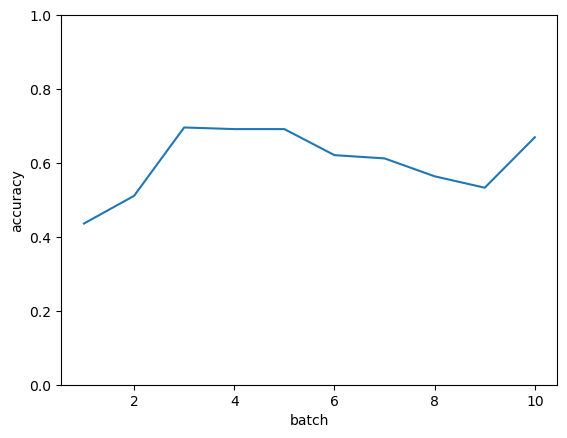

In [34]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

SGD_raw = SGDClassifier(random_state=70)
mini_batch = 227
epoch = 10
train_score = []

for i in range(epoch):
    feature_batch = feature_train.iloc[i * mini_batch : (i + 1) * mini_batch,]
    label_batch = label_train.iloc[i * mini_batch : (i + 1) * mini_batch,]
    if i>0:
        SGD_raw.partial_fit(feature_batch, np.ravel(label_batch))
        train_score.append([i+1, SGD_raw.score(feature_batch, label_batch)])
    else:
        SGD_raw.partial_fit(feature_batch, np.ravel(label_batch), classes=range(2))
        train_score.append([i+1, SGD_raw.score(feature_batch, label_batch)])

batch_data = pd.DataFrame(train_score, columns = ["batch", "accuracy"])

sns.lineplot(
data=batch_data, x="batch", y="accuracy").set_ylim(0,1)

In [24]:
prediction_batch = SGD_raw.predict(feature_test)

<p style = "font-size:14pt">
<b>Step 4. 結果評估</b>
</p>
<p style = "font-size:12pt">
因為這邊想要評估的是模型的整體表現，所以用macro average的方式做。
</p>

In [25]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# 寫成function之後比較好用

def model_metrics(prediction, label): # 定義一個新功能叫做model_metrics，裡面需要prediction跟label兩個參數。然後作下面這然後做下面這些事情    
    evaluation = precision_recall_fscore_support(label, prediction, average='macro') # 計算precision, recall, F-score
    accuracy = accuracy_score(label, prediction) # 計算accuracy

    # 印出評估結果
    print("accuracy: " + str(round(accuracy, 2)) + "\nprecision: " + str(round(evaluation[0], 2)) + "\nrecall: " + str(round(evaluation[1], 2)) + "\nfscore: " + str(round(evaluation[2],2)))

<p style = "font-size:12pt">
✨Default Logistic Regression 模型
</p>

In [26]:
model_metrics(prediction_default, label_test)

accuracy: 0.68
precision: 0.68
recall: 0.68
fscore: 0.68


<p style = "font-size:12pt">
✨lbfgs + none
</p>

In [27]:
model_metrics(prediction_lbfgs_none, label_test)

accuracy: 0.7
precision: 0.7
recall: 0.7
fscore: 0.7


<p style = "font-size:12pt">
✨liblinear + l1<br>
</p>

In [28]:
model_metrics(prediction_liblinear_l1, label_test)

accuracy: 0.69
precision: 0.69
recall: 0.69
fscore: 0.69


<p style = "font-size:12pt">
✨liblinear + l2<br>
</p>

In [29]:
model_metrics(prediction_liblinear_l2, label_test)

accuracy: 0.69
precision: 0.69
recall: 0.69
fscore: 0.69


<p style = "font-size:12pt">
✨optimal SGD<br>
</p>

In [30]:
model_metrics(prediction_SGD_optimal, label_test)

accuracy: 0.7
precision: 0.7
recall: 0.7
fscore: 0.7


<p style = "font-size:12pt">
✨constant SGD<br>
</p>

In [31]:
model_metrics(prediction_SGD_constant, label_test)

accuracy: 0.69
precision: 0.69
recall: 0.69
fscore: 0.69


<p style = "font-size:12pt">
✨invscaling SGD<br>
</p>

In [32]:
model_metrics(prediction_SGD_invscaling, label_test)

accuracy: 0.66
precision: 0.66
recall: 0.66
fscore: 0.66


<p style = "font-size:12pt">
✨用了 mini-batch 的 SGD<br>
</p>

In [33]:
model_metrics(prediction_batch, label_test)

accuracy: 0.68
precision: 0.7
recall: 0.68
fscore: 0.67


<p style = "font-size:12pt">
✨分數統整<br>
</p>
<table>
<tr style = "background-color: #FFECF5">
  <th>&emsp;&emsp;</th>
  <th>accuracy</th>
  <th>precision</th>
  <th>recall</th>
  <th>f-score</th>
<tr>
<tr>
  <td style = "background-color: 	#D2E9FF">default LR</td>
  <td>0.68</td>
  <td>0.68</td>
  <td>0.68</td>
  <td>0.68</td>
</tr>
<tr>
  <td style = "background-color: 	#D2E9FF">lbfgs + none</td>
  <td>0.70</td>
  <td>0.70</td>
  <td>0.70</td>
  <td>0.70</td>
</tr>
<tr>
  <td style = "background-color: 	#D2E9FF">liblinear + l1</td>
  <td>0.69</td>
  <td>0.69</td>
  <td>0.69</td>
  <td>0.69</td>
</tr>
<tr>
  <td style = "background-color: 	#D2E9FF">liblinear + l2</td>
  <td>0.69</td>
  <td>0.69</td>
  <td>0.69</td>
  <td>0.69</td>
</tr>
<tr>
  <td style = "background-color: 	#D2E9FF">optimal SGD</td>
  <td>0.70</td>
  <td>0.70</td>
  <td>0.70</td>
  <td>0.70</td>
</tr>
<tr>
  <td style = "background-color: 	#D2E9FF">constant SGD</td>
  <td>0.69</td>
  <td>0.69</td>
  <td>0.69</td>
  <td>0.69</td>
</tr>
<tr>
  <td style = "background-color: 	#D2E9FF">invscaling SGD</td>
  <td>0.66</td>
  <td>0.66</td>
  <td>0.66</td>
  <td>0.66</td>
</tr>
<tr>
  <td style = "background-color: 	#D2E9FF">mini-batch</td>
  <td>0.68</td>
  <td>0.70</td>
  <td>0.68</td>
  <td>0.67</td>
</tr>
  </table>

<p style = "font-size:12pt">
✨learning-rate 變換<br>
</p>

In [97]:
rates = []
for i in range(30):
    rate = 0.1*(i+1)
    rate_model = SGDClassifier(loss="log", learning_rate="constant", max_iter=500, eta0=rate, random_state=168).fit(feature_train, np.ravel(label_train))
    prediction = rate_model.predict(feature_test)
    fscore = precision_recall_fscore_support(label_test, prediction, average="macro")[2]
    rates.append([round(rate,1), round(fscore,2)])

rate_data = pd.DataFrame(rates, columns = ["learning-rate", "f-score"])

for i in range(10):
    print("learning-rate: "+str(rates[i][0])+" / f-score: "+str(rates[i][1])+" | learning-rate: "+str(rates[i+1][0])+" / f-score: "+str(rates[i+1][1])+" | learning-rate: "+str(rates[i+2][0])+" / f-score: "+str(rates[i+2][1]))

learning-rate: 0.1 / f-score: 0.69 | learning-rate: 0.2 / f-score: 0.68 | learning-rate: 0.3 / f-score: 0.69
learning-rate: 0.2 / f-score: 0.68 | learning-rate: 0.3 / f-score: 0.69 | learning-rate: 0.4 / f-score: 0.67
learning-rate: 0.3 / f-score: 0.69 | learning-rate: 0.4 / f-score: 0.67 | learning-rate: 0.5 / f-score: 0.67
learning-rate: 0.4 / f-score: 0.67 | learning-rate: 0.5 / f-score: 0.67 | learning-rate: 0.6 / f-score: 0.65
learning-rate: 0.5 / f-score: 0.67 | learning-rate: 0.6 / f-score: 0.65 | learning-rate: 0.7 / f-score: 0.64
learning-rate: 0.6 / f-score: 0.65 | learning-rate: 0.7 / f-score: 0.64 | learning-rate: 0.8 / f-score: 0.63
learning-rate: 0.7 / f-score: 0.64 | learning-rate: 0.8 / f-score: 0.63 | learning-rate: 0.9 / f-score: 0.62
learning-rate: 0.8 / f-score: 0.63 | learning-rate: 0.9 / f-score: 0.62 | learning-rate: 1.0 / f-score: 0.6
learning-rate: 0.9 / f-score: 0.62 | learning-rate: 1.0 / f-score: 0.6 | learning-rate: 1.1 / f-score: 0.59
learning-rate: 1.0 / 

(0.0, 1.0)

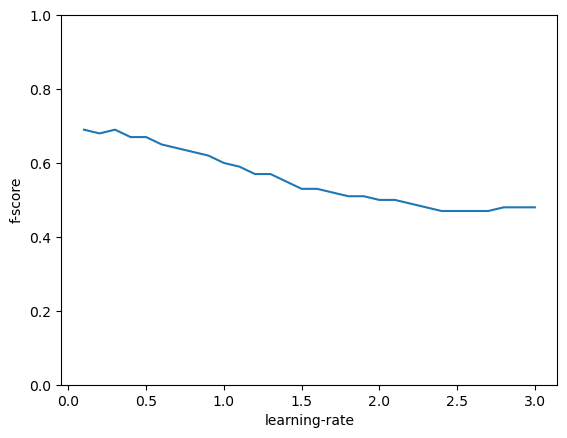

In [98]:
sns.lineplot(
data=rate_data, x="learning-rate", y="f-score").set_ylim(0,1)

<p align = "center", style = "font-size:16pt">
    🧐<b>討論</b>🧐<br>
</p>
<p style = "font-size:12pt">
   &emsp;&emsp;從表格裡面可以發現，調整了不同參數的簡單LR模型做出來的結果都差不多，又以<code>lfbgs</code>不使用penalty的組合最好，可以達到0.7的F-score。推測會有這樣的結果是因為兩種演算法確實都適用於少量資料的分類任務（說實話我還是不太確定到底要到多少才是大）。另外，上面沒有提到<code>lfbgs</code>的一大特色就是在計算的過程中他只保留比較重要的參數資料，所以很節省記憶體。可能是因為這樣他才被選擇作為預設的演算法。只是在這次作業的小資料應用跟以F-score評估的方式裡面可能就看不出差別。<br>
   &emsp;&emsp;使用SGD的LR模型裡面，<code>optimal</code>模式的learning rate出來的結果是三種裡面最好的。這個部分可以明顯看出三種模式的差異性。因為<code>constant</code>模式在模型訓練的過程中始終使用相同的數值，所以一定比逐步調整更新的<code>optimal</code>表現要差；而<code>invscaling</code>則是常用於regression的模式，因此在分類任務上的結果就比較不理想。<br>
   &emsp;&ensp;最後從用不同learning rate訓練出模型之F-score可以發現在0.1~3.0之間，當learning rate越大，訓練出的模型表現越差。這其實也跟SGD模型裡面<code>optimal</code>模式的算法相互映證。在該模式中，learning rate會隨著時間遞進逐步向下調整使模型達到更佳的表現。由此我們可以找到對learning rate調整的大致方向應該如何進行。
</p>
